In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color

%matplotlib inline

In [5]:
def check_mem():
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in globals() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

def get_file_list(df, folder, n_sample = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    img = transform.resize(img, (w, h), mode='constant', anti_aliasing=True)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :]
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n)
    images = read_images_4d_array(files_list)
    return images

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

def get_final_matrices(n_train = None, n_test = None):
    x_boys_train = get_images_matrix('boys_train.csv', 'boys', n_train)
    x_boys_test = get_images_matrix('boys_test.csv', 'boys', n_test)
    x_girls_train = get_images_matrix('girls_train.csv', 'girls', n_train)
    x_girls_test = get_images_matrix('girls_test.csv', 'girls', n_test)
    
    x_boys_train_all = get_all_pixels(x_boys_train)
    x_boys_test_all = get_all_pixels(x_boys_test)
    x_girls_train_all = get_all_pixels(x_girls_train)
    x_girls_test_all = get_all_pixels(x_girls_test)

    x_train = np.vstack([x_boys_train_all, x_girls_train_all])
    x_test = np.vstack([x_boys_test_all, x_girls_test_all])

    y_boys_train = np.array([0] * x_boys_train.shape[0])
    y_boys_test = np.array([0] * x_boys_test.shape[0])
    y_girls_train = np.array([1] * x_girls_train.shape[0])
    y_girls_test = np.array([1] * x_girls_test.shape[0])
    y_train = np.concatenate([y_boys_train, y_girls_train])
    y_test = np.concatenate([y_boys_test, y_girls_test])
    
    return x_train, x_test, y_train, y_test

## Load 10% of data

In [ ]:
x_train, x_test, y_train, y_test = get_final_matrices(n_train = 1000, n_test = 250)

In [13]:
print('x_train shape: %d rows, %d columns' % x_train.shape)
print('x_test shape: %d rows, %d columns' % x_test.shape)
print('y_train length: %d' % len(y_train))
print('y_test length: %d' % len(y_test))

x_train shape: 2000 rows, 30000 columns
x_test shape: 500 rows, 30000 columns
y_train length: 2000
y_test length: 500


In [6]:
check_mem()

[('x_train', 480000112), ('x_test', 120000112), ('y_train', 16096), ('y_test', 4096), ('get_file_list', 136), ('read_image_and_resize', 136), ('read_images_4d_array', 136), ('get_images_matrix', 136), ('get_all_pixels', 136), ('get_final_matrices', 136), ('check_mem', 136), ('pd', 80), ('np', 80), ('plt', 80), ('transform', 80), ('color', 80)]


## PCA

In [28]:
from sklearn.decomposition import PCA

x_train_centered = x_train - x_train.mean(axis = 0)
x_test_centered = x_test - x_train.mean(axis = 0) # notice we use x_train means

pca = PCA(n_components = 100)

pca.fit(x_train_centered)
W = pca.components_

x_train_reduced = np.matmul(x_train_centered, W.T)
x_test_reduced = np.matmul(x_test_centered, W.T)

print('x_train_reduced shape: %d rows, %d columns' % x_train_reduced.shape)

x_train_reduced shape: 2000 rows, 100 columns


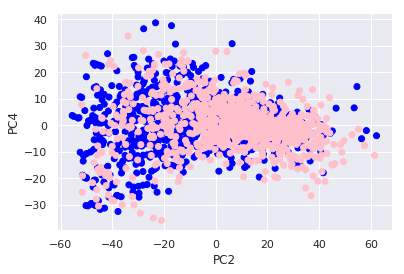

In [27]:
plt.scatter(x_train_reduced[:,1], x_train_reduced[:,3], color=['blue' for i in range(1000)] + ['pink' for i in range(1000)])
plt.xlabel('PC2')
plt.ylabel('PC4')
plt.show()

## Logistic Regression

In [7]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression()
mod.fit(x_train, y_train)
acc = mod.score(x_test, y_test)
print('Accuracy of LR on all pixels: %.2f' % acc)

Accuracy of LR on all pixels: 0.70


In [29]:
mod = LogisticRegression()
mod.fit(x_train_reduced, y_train)
acc = mod.score(x_test_reduced, y_test)
print('Accuracy of LR on first 100 PCs: %.2f' % acc)

Accuracy of LR on first 100 PCs: 0.71


## Classification Tree

In [8]:
from sklearn.tree import DecisionTreeClassifier

mod = DecisionTreeClassifier()
mod.fit(x_train, y_train)
acc = mod.score(x_test, y_test)
print('Accuracy of CART on all pixels: %.2f' % acc)

Accuracy of CART on all pixels: 0.68


In [30]:
mod = DecisionTreeClassifier()
mod.fit(x_train_reduced, y_train)
acc = mod.score(x_test_reduced, y_test)
print('Accuracy of CART on first 100 PCs: %.2f' % acc)

Accuracy of CART on first 100 PCs: 0.62


## Random Forests

In [31]:
from sklearn.ensemble import RandomForestClassifier

mod = RandomForestClassifier(n_estimators = 100)
mod.fit(x_train, y_train)
acc = mod.score(x_test, y_test)
print('Accuracy of RF on all pixels: %.2f' % acc)

Accuracy of RF on all pixels: 0.77


In [32]:
mod = RandomForestClassifier(n_estimators = 100)
mod.fit(x_train_reduced, y_train)
acc = mod.score(x_test_reduced, y_test)
print('Accuracy of RF on first 100 PCs: %.2f' % acc)

Accuracy of RF on first 100 PCs: 0.75


## Boosting Trees

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

mod = GradientBoostingClassifier(n_estimators = 100)
mod.fit(x_train, y_train)
acc = mod.score(x_test, y_test)
print('Accuracy of Boosting on all pixels: %.2f' % acc)

Accuracy of RF on all pixels: 0.77


In [34]:
mod = GradientBoostingClassifier(n_estimators = 100)
mod.fit(x_train_reduced, y_train)
acc = mod.score(x_test_reduced, y_test)
print('Accuracy of Boosting on first 100 PCs: %.2f' % acc)

Accuracy of Boosting on first 100 PCs: 0.74
